### Algorithm As A Sequence
* Takes in the user creds, which comes in as an user object, it then segregates the user into regular or premium.
* For Regular Users :
    * It Takes the rating of restaurants and displays them in the descending order of rating
    * It gets this rating by performing a sentiment analysis of the reviews given by the users
* For Premium Users : 
    * It takes in the BMI of the users, 

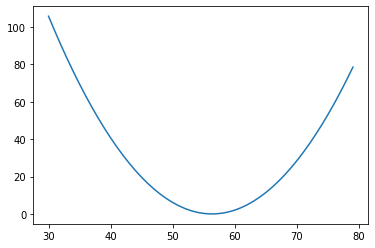

In [35]:

def getIdealWeight(height):
    return 22*height**2
def getRevisedCaloriesPerDay(weight_gap, diet_days=10, per_day_cal=2500):
    return 2500 - weight_gap*7700/diet_days
    

import matplotlib.pyplot as plt
weight = [w for w in range(30, 80)]
height = [h/100 for h in range(150, 170)]
BMIs = [(22-w/height[10]**2)**2 for w in weight]
plt.plot(weight, BMIs)



In [16]:
getIdealWeight(1.6)

56.32000000000001

In [34]:
from math import ceil
weight_gap = 10
x = ceil((weight_gap)*7700/2500)
f"{x} days to diet"

'31 days to diet'

In [ ]:
getRevisedCaloriesPerDay(20, diet_days=10, per_cal_

In [3]:
"hello"

'hello'

In [ ]:
present_weight - desired_weight = (x)*10/7700  